# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import sys, os, gc
from tqdm import trange, tqdm
from IPython.display import clear_output
sys.path.append('..')
import lfi
import global_config
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='4'
torch.backends.cudnn.deterministic = True
dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
dataset = np.load('../datasets/HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)
dataset_P = torch.from_numpy(dataset_P).to(device, dtype)
dataset_Q = torch.from_numpy(dataset_Q).to(device, dtype)
del dataset

# Load Trained Model
You may change to other checkpoints.

In [5]:
sys.path.append('../methods/Mix')
from model import Model
kernel = torch.load('../methods/Mix/checkpoints00/n_tr=1300000#0/kernel.pt')

# Run simulations

In [12]:
n_ev_list = 10**np.linspace(0.5, 4, 20)
n_ev_list = n_ev_list.astype(int)[::-1]
m_list = 10**np.linspace(0.5, 4, 20)
m_list = m_list.astype(int)
repeats = range(10)
pi = 0.1
n_cal = 20000
batch_size = 10000


In [13]:
type_1_error_mat = np.zeros((len(n_ev_list), len(m_list), len(repeats)))
type_2_error_mat = np.zeros((len(n_ev_list), len(m_list), len(repeats)))

In [14]:
gc.collect(); torch.cuda.empty_cache()
for i, n_ev in enumerate(n_ev_list):
    type_1_error, type_2_error = lfi.test.simulate_error(dataset_P, dataset_Q,
                                                            1300000, n_cal, n_ev, 
                                                            kernel, repeats,
                                                            pi, m_list,
                                                            batch_size,
                                                            plot_hist_path='../assets/hist.png',
                                                            verbose=True)
    type_1_error_mat[i, :, :] = type_1_error
    type_2_error_mat[i, :, :] = type_2_error
    clear_output(wait=True)
# np.save('Type12_mat.npy', Type12_mat)
# np.save('type_1_error_mat.npy', type_1_error_mat)
# np.save('type_2_error_mat.npy', type_2_error_mat)
# np.save('Type1_mat.npy', Type1_mat) 
# np.save('Type2_mat.npy', Type2_mat)


progress in repeating n_tr=1300000, n_ev=3:   0%|          | 0/10 [00:00<?, ?it/s]

plotting histogram to ../assets/hist.png


progress in repeating n_tr=1300000, n_ev=3:  10%|█         | 1/10 [00:01<00:14,  1.60s/it]

plotting histogram to ../assets/hist.png


progress in repeating n_tr=1300000, n_ev=3:  20%|██        | 2/10 [00:03<00:13,  1.64s/it]

plotting histogram to ../assets/hist.png


progress in repeating n_tr=1300000, n_ev=3:  30%|███       | 3/10 [00:04<00:11,  1.63s/it]

plotting histogram to ../assets/hist.png


progress in repeating n_tr=1300000, n_ev=3:  40%|████      | 4/10 [00:06<00:09,  1.63s/it]

plotting histogram to ../assets/hist.png


progress in repeating n_tr=1300000, n_ev=3:  50%|█████     | 5/10 [00:08<00:07,  1.58s/it]

plotting histogram to ../assets/hist.png


progress in repeating n_tr=1300000, n_ev=3:  60%|██████    | 6/10 [00:09<00:05,  1.45s/it]

plotting histogram to ../assets/hist.png


progress in repeating n_tr=1300000, n_ev=3:  70%|███████   | 7/10 [00:10<00:04,  1.42s/it]

plotting histogram to ../assets/hist.png


progress in repeating n_tr=1300000, n_ev=3:  80%|████████  | 8/10 [00:12<00:03,  1.50s/it]

plotting histogram to ../assets/hist.png


progress in repeating n_tr=1300000, n_ev=3:  90%|█████████ | 9/10 [00:13<00:01,  1.44s/it]

plotting histogram to ../assets/hist.png


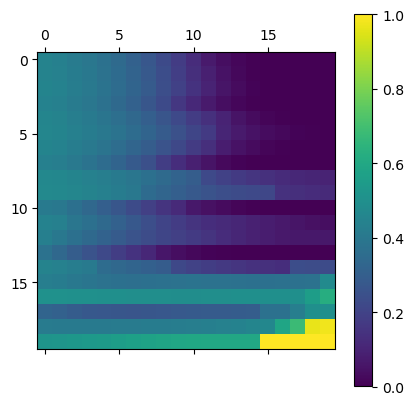

In [15]:
def not_outlier(A, axis=2):
    mask = np.abs(A)>0
    mean = np.mean(A, axis, keepdims=True, where=mask)
    std = np.std(A, axis, keepdims=True, where=mask)
    scores = (A-mean)/std
    output = np.logical_and(np.abs(scores)<2, mask)
    return output
Type1_mat = np.mean(type_1_error_mat, where = not_outlier(type_1_error_mat), axis=2)
Type2_mat = np.mean(type_2_error_mat, where = not_outlier(type_2_error_mat), axis=2)
Type12_mat = Type1_mat + Type2_mat
clear_output(wait=True)
plt.matshow(Type1_mat)
plt.colorbar()

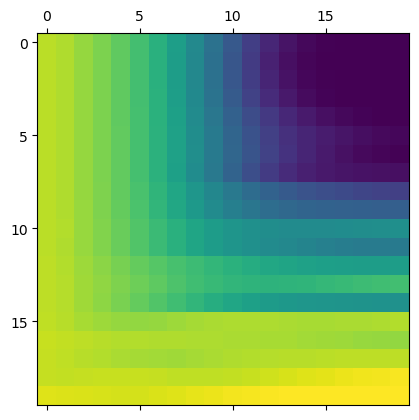

In [19]:
Type1_mat = np.mean(type_1_error_mat, axis=2)
Type2_mat = np.mean(type_2_error_mat, axis=2)
Type12_mat = Type1_mat + Type2_mat
plt.matshow(Type12_mat)

# Plot

In [17]:
# Type12_mat = np.load('Type12_mat.npy')

[0.1        0.12845442 0.16057272 0.19590892 0.2339067  0.27394203
 0.31536447 0.35753323 0.39984607 0.44176023 0.48280553 0.52259074
 0.56080433 0.59721112 0.63164603 0.66400608 0.69424168 0.72234762
 0.74835465 0.77232155 0.79432823]


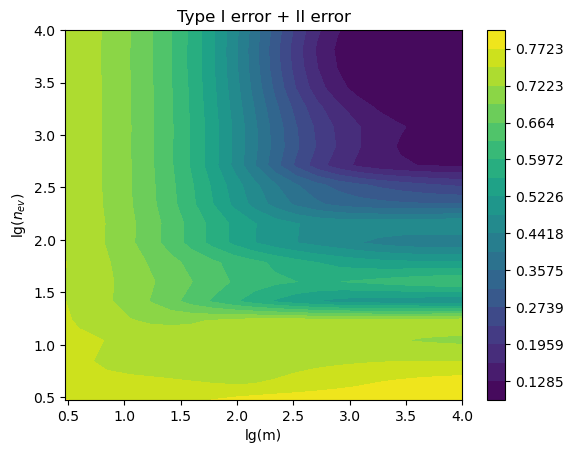

In [20]:
Type12_mat_log = -np.log10(-np.log10(Type12_mat))
levels = 20
fig, ax = plt.subplots()
contourf_ = ax.contourf(np.log10(m_list), np.log10(n_ev_list), Type12_mat, levels=levels)
cb = fig.colorbar(contourf_)
log_log_p_list = cb.mappable.levels 
real_p_list = 10**(-(10**(-log_log_p_list)))
print(real_p_list)
real_p_list = np.around(real_p_list, decimals=4)
real_p_list = real_p_list.astype(str)
# real_p_list[0] = '1.42e-16'
# real_p_list[1] = '6.02e-12'
# real_p_list[2] = '1.14e-08'
# real_p_list[3] = '2.38e-06'
cb.set_ticks(log_log_p_list[1:-1:2])
cb.set_ticklabels(real_p_list[1:-1:2])
# plt.xlim(1, 4)
# plt.ylim(1, 4)
plt.xlabel('lg(m)')
plt.ylabel('lg($n_{ev}$)')
plt.title('Type I error + II error')
plt.savefig('Type12_mat.pdf', dpi=300)